In [1]:
# ============================
# 1) Data collection & Definition 
# ============================

from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(
    root=r"D:\my projects\CV\dataset images", transform=transform
)

path = r"D:\my projects\CV\dataset images"

from torchvision import datasets, transforms

print(f"number of images = {len(dataset)}")
print(f"number of classes = {len(dataset.classes)}")
print(f"name of classes : {dataset.classes}")


def define_problem():
    return {
        "problem": "classify data to 23 class",
        "success_metrics": ["accuracy > 80%", "balanced precision"],
        "constraints": ["13.7K images", "23 class", "potential imbalance"],
    }


print(f"problem definition : {define_problem()}")

number of images = 13711
number of classes = 23
name of classes : ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']
problem definition : {'problem': 'classify data to 23 class', 'success_metrics': ['accuracy > 80%', 'balanced precision'], 'constraints': ['13.7K images', '23 class', 'potential imbalance']}


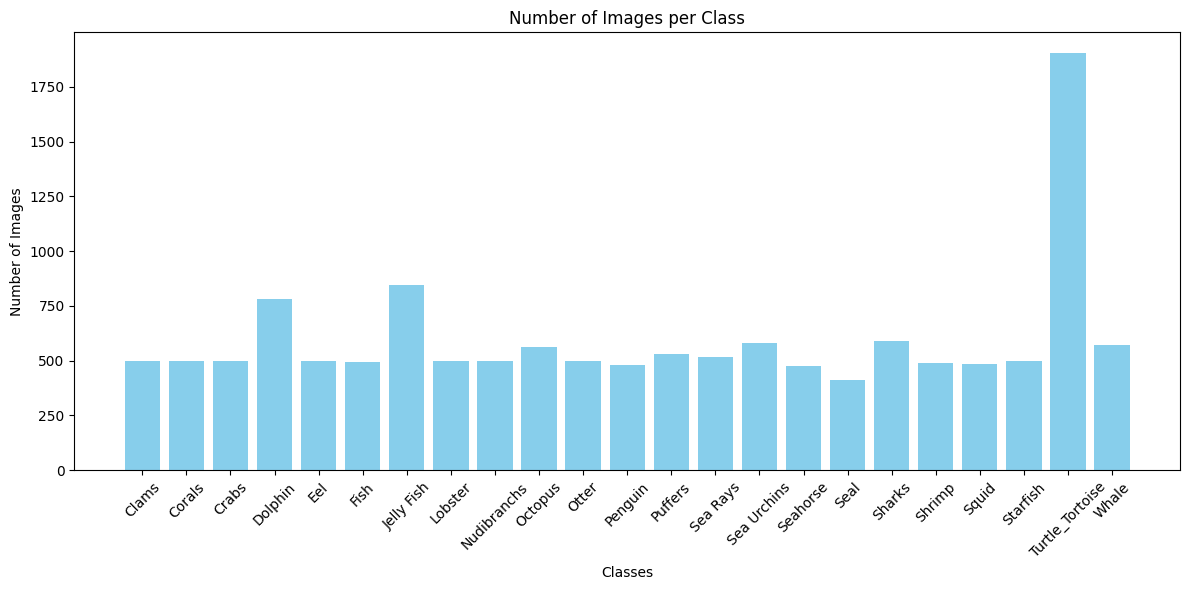

In [2]:
# ==============================
# 2) Data analysis
# ==============================

import matplotlib.pyplot as plt
import os

class_names = []
image_counts = []

for class_name in dataset.classes:
    class_path = os.path.join(path, class_name)
    num_images = len(os.listdir(class_path))
    class_names.append(class_name)
    image_counts.append(num_images)

plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts, color="skyblue")
plt.title("Number of Images per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# =======================
# 3) Data cleaning
# =======================

import os
import random


def balance_class_in_place(path, target_class, target_count):

    class_path = os.path.join(path, target_class)

    all_images = [
        img
        for img in os.listdir(class_path)
        if os.path.isfile(os.path.join(class_path, img))
    ]

    current_count = len(all_images)

    if current_count > target_count:

        images_to_remove = random.sample(all_images, current_count - target_count)
        for img in images_to_remove:
            img_path = os.path.join(class_path, img)
            os.remove(img_path)

        print("images minimized !")
        return True


balance_class_in_place(path, "Turtle_Tortoise", 700)

images minimized !


True

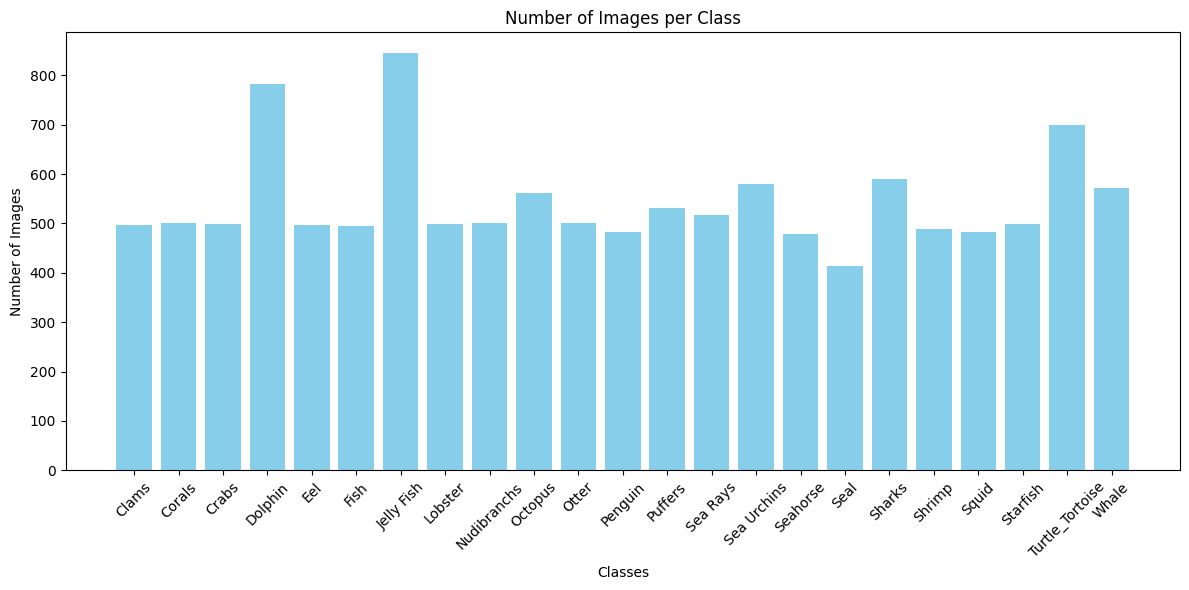

In [4]:
# ============================
# 4) Load balanced dataset
# ============================

new_path = r"D:\my projects\CV\dataset images"
edited_dataset = ImageFolder(root=new_path, transform=transforms.ToTensor())

class_names = []
image_counts = []

for class_name in edited_dataset.classes:
    class_path = os.path.join(new_path, class_name)
    num_images = len(os.listdir(class_path))
    class_names.append(class_name)
    image_counts.append(num_images)

plt.figure(figsize=(12, 6))
plt.bar(class_names, image_counts, color="skyblue")
plt.title("Number of Images per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# ============================
# 5)Data augmenatation
# ============================

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
# ============================
# 6)Load edited dataset with train_transform
# ============================

edited_dataset = datasets.ImageFolder(root=new_path, transform=train_transform)


train_size = int(0.8 * len(edited_dataset))
val_size = len(edited_dataset) - train_size
train_dataset, val_dataset = random_split(edited_dataset, (train_size, val_size))


batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [7]:
# ================
# 7)Model design
# ================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from torchvision import models

model = models.resnet18(pretrained=True)
num_classes = len(dataset.classes)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001
)

c:\Users\STAR4\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\STAR4\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# ================
# 8)Model Train
# ================

EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()

In [9]:
# ================
# 9)Model Test
# ================

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
            
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

val_acc = 100 * correct / total
avg_loss = running_loss / len(train_loader)

print(f"Epoch [{epoch+1}/{EPOCHS}] "
      f"| Loss: {avg_loss:.4f} "
      f"| Validation Accuracy: {val_acc:.2f}%")
    
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:

        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"\nFinal Test Accuracy = {test_acc:.2f}%")


torch.save(model.state_dict(), "resnet18_animals.pth")
print("model saved")

Epoch [5/5] | Loss: 0.3124 | Validation Accuracy: 81.77%

Final Test Accuracy = 81.81%
model saved
